### CMB Assigment 2 Program ###

In [1]:
# Program, run imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

Create Pandas Dataframe

In [2]:
#df = pd.read_csv("data/21-12-23_complete.csv")
data_folder = "C:/Users/maxim/Documents/RaspData/Preprocessed Data/"
df = pd.read_csv(data_folder + "data/2022-01-16_test.csv")
#df = pd.read_csv("data/2022-01-04_complete.csv")
print(df)
print(df)
# ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info', 'dst port']


           No.                        Time          Source     Destination  \
0            1  2022-01-16 14:38:27,875387  193.122.47.231  192.168.178.59   
1            2  2022-01-16 14:38:27,877933  192.168.178.59  193.122.47.231   
2            3  2022-01-16 14:38:27,892040  193.122.47.231  192.168.178.59   
3            4  2022-01-16 14:38:27,904171  192.168.178.59  193.122.47.231   
4            5  2022-01-16 14:38:27,915192  193.122.47.231  192.168.178.59   
...        ...                         ...             ...             ...   
605569  605570  2022-01-16 15:23:11,362857  192.168.178.59  52.223.201.135   
605570  605571  2022-01-16 15:23:11,365031  193.122.47.231  192.168.178.59   
605571  605572  2022-01-16 15:23:11,367378  192.168.178.59  52.223.201.135   
605572  605573  2022-01-16 15:23:11,378692  193.122.47.231  192.168.178.59   
605573  605574  2022-01-16 15:23:11,378886  52.223.201.135  192.168.178.59   

       Protocol  Length                                        

In [3]:
# helper functions
def utcEntryToTimestamp(entry):
    row_entry = entry.split(",")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.loc[0])
# print(df.loc[0].at['Time'])

1642340307

### Protocol packet distribution ###

Protocol
0x8899         2681
0x8912         1344
ARP            1781
BROWSER          71
DHCP              4
DNS            1910
HTTP            118
HTTP/XML         34
ICMP             19
ICMPv6          176
IGMPv3           44
LLC               5
LLDP             89
MDNS            317
NBNS             48
NBSS              1
NTP              10
OCSP             30
QUIC           1173
SSDP            245
SSL              51
SSLv2            60
TCP          126703
TLSv1.2       28613
TLSv1.3       19266
UDP          420778
WireGuard         2
XMPP/XML          1
Name: Source, dtype: int64


C:\Users\maxim\AppData\Local\Temp/ipykernel_19828/3437212219.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


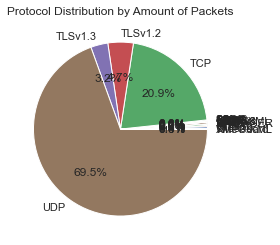

In [4]:
print(df.groupby('Protocol').Source.count())

count_protocol_packets = df.groupby('Protocol').Source.count()

fig, ax = plt.subplots()
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(count_protocol_packets, labels=count_protocol_packets.keys(), autopct='%1.1f%%',)
fig.show()

### Amount of data traffic per protocol ###

Protocol
0x8899          160860
0x8912           80640
ARP              90016
BROWSER          17469
DHCP              1848
DNS             244972
HTTP             89818
HTTP/XML         27312
ICMP              1969
ICMPv6           15844
IGMPv3            2684
LLC                300
LLDP              9434
MDNS             47502
NBNS              4440
NBSS                55
NTP                980
OCSP             20177
QUIC            815938
SSDP             96188
SSL              18604
SSLv2            89966
TCP          100471690
TLSv1.2       13388331
TLSv1.3       23082925
UDP          140034906
WireGuard          246
XMPP/XML           125
Name: Length, dtype: int64


C:\Users\maxim\AppData\Local\Temp/ipykernel_19828/3869399598.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


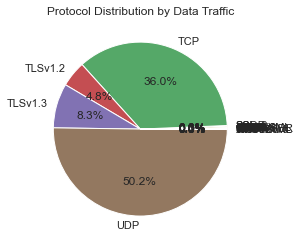

In [5]:
count_protocol_traffic = df.groupby('Protocol').Length.sum()
print(count_protocol_traffic)
fig, ax = plt.subplots()
plt.title('Protocol Distribution by Data Traffic')
ax.pie(count_protocol_traffic, labels=count_protocol_traffic.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per Protocol Type ###

Protocol
0x8899         60.000000
0x8912         60.000000
ARP            50.542392
BROWSER       246.042254
DHCP          462.000000
DNS           128.257592
HTTP          761.169492
HTTP/XML      803.294118
ICMP          103.631579
ICMPv6         90.022727
IGMPv3         61.000000
LLC            60.000000
LLDP          106.000000
MDNS          149.848580
NBNS           92.500000
NBSS           55.000000
NTP            98.000000
OCSP          672.566667
QUIC          695.599318
SSDP          392.604082
SSL           364.784314
SSLv2        1499.433333
TCP           792.970095
TLSv1.2       467.910775
TLSv1.3      1198.117149
UDP           332.799971
WireGuard     123.000000
XMPP/XML      125.000000
Name: Length, dtype: float64


C:\Users\maxim\AppData\Local\Temp/ipykernel_19828/687483302.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


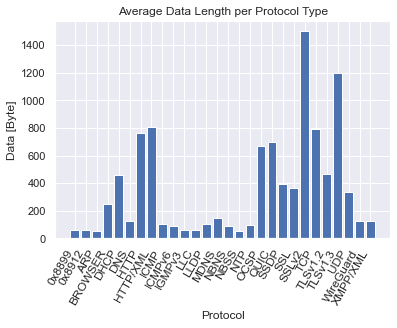

In [6]:
average_protocol_packet_length = df.groupby('Protocol').Length.sum() / df.groupby('Protocol').Length.count()
print(average_protocol_packet_length)
fig, ax = plt.subplots()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Average Data Length per Protocol Type')
ax.bar(average_protocol_packet_length.keys(), average_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

### Source addresses ###

In [7]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

Source
0.0.0.0                        2
104.121.164.88               442
104.121.178.102               85
104.122.84.42                 15
104.16.119.50                 42
                            ... 
fe80::473:1710:925f:bc41      11
fe80::84b4:51be:6c99:6c77     31
fe80::8811:479e:5a49:cb2c     41
fe80::ba27:ebff:fe98:7cbe      8
fe80::e228:6dff:fe67:1d98     32
Name: Time, Length: 247, dtype: int64
Destination
192.168.178.25                                1
ff02::1:ff2c:7c23                             1
133.243.238.164                               1
195.201.95.254                                1
ff02::2                                       1
                                          ...  
2003:c1:3712:ac00:4979:8280:612c:7c23     13361
52.223.201.135                            15311
192.168.178.21                            16063
193.122.47.231                           234248
192.168.178.59                           272888
Name: Time, Length: 251, dtype: int64


### DNS requests ###

In [8]:
df_dns = df[df['Protocol'].isin(['DNS'])]
df_dns.head()
df_dns_requests_1 = df_dns[df_dns['Info'].str.contains('Standard query')]
# does not contain response
df_dns_requests_2 = df_dns_requests_1[~df_dns_requests_1['Info'].str.contains('response')]
df_dns_resources = df_dns_requests_2['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print(df_dns_resources)
# print(df_dns_requests)
# print(df_dns['Info'])


BRW68140127B12B.fritz.box       127
oauth.reddit.com                 30
alb.reddit.com                   28
e.reddit.com                     23
profile.accounts.firefox.com     20
                               ... 
esports-api.lolesports.com        1
cmp.osano.com                     1
api.naea1.uds.lenovo.com          1
filedownload.lenovo.com           1
crl3.digicert.com                 1
Name: Info, Length: 235, dtype: int64


### Data traffic over time ###

from  1642340307  to  1642342991
4
[ 66252. 177503. 185426. 176393.]
[ 17557.  88201.  61493. 111563.]


C:\Users\maxim\AppData\Local\Temp/ipykernel_19828/2614995985.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\maxim\AppData\Local\Temp/ipykernel_19828/2614995985.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


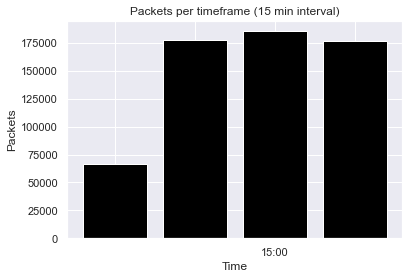

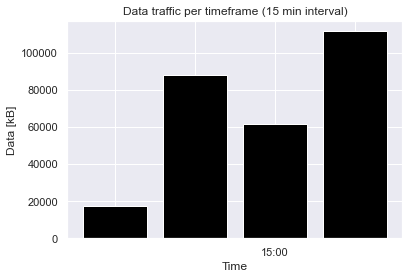

In [9]:
def timeMapping(x):
    # include time difference UTC+1
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 3 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

# find first and last timestamp, then create data structure
min_15_duration = 60 * 15
df_time_mod = df.copy()
df_time_mod['Time'] = df_time_mod['Time'].apply(lambda x: utcEntryToTimestamp(x)) # map to 15 min window
df_time_mod.head()
first_entry = df_time_mod.loc[0].at['Time'] // min_15_duration
last_entry = df_time_mod.iloc[-1].at['Time'] // min_15_duration

print('from ', df_time_mod.loc[0].at['Time'], " to ", df_time_mod.iloc[-1].at['Time'])

count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)

x_values_packets = list(range(first_entry, last_entry + 1))
print(len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets))

# print(mapping_res)

for index, row in df_time_mod.iterrows():
    ts = row.at['Time'] // min_15_duration
    count_packets[ts - first_entry] += 1
    length_packets[ts - first_entry] += row.at['Length']

length_packets = length_packets // 1000
print(count_packets)
print(length_packets)

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()